# MNIST 이미지 셋 분류기 만들기

## 패키지 참조 및 데이터 준비

- load_data()는 s3에 있는 mnist 파일을 다운받아 ~/.keras/datasets 폴더에 캐시한다.
- 파일은 .npz 포맷으로 되어 있고, x_train, y_train, x_test, y_test이름의 배열을 읽어서 tuple로 리턴한다.

In [1]:
from tensorflow.keras.datasets.fashion_mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

# keras의 mnist 입력 데이터는 60000개의 28 x 28 uint8로 이루어져 있다.

print(x_train.shape, x_train.dtype)

(60000, 28, 28) uint8


## 데이터 전처리

- 기본 CNN 골격에 맞게 28x28x1로 차원을 변경하고 uint8을 float으로 바꾼다.
- 각 픽셀의 값은 [0, 255] 사이의 값이므로 255로 나누어 [0, 1]로 맞춘다.

In [2]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

- keras util의 to_categorical 함수로 label에 해당하는 [0, 9] 사이의 숫자 y를 바이너리 배열로 변환한다. (one-hot encoding)

In [3]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## 모델 설계

- Sequential은 layer를 순차적으로 연결하는 모델이다.
- .add() 명령으로 layer를 추가할 수 있다.
- keras의 layer와 convolutional에 이미 정의된 클래스들이 있어서 인자만 넘기면 쉽게 생성할 수 있다.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [5]:
model = Sequential()

#### Conv2D
- filters: 필터(커널)의 개수
- kernel_size: 필터의 크기
- strides: 필터의 이동 간격
- padding: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
- activation: 활성화 함수
- input_shape: 첫 레이어에 인풋으로 들어오는 크기

#### MaxPool2D

- 컨볼루션 렝어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
- pool_size: 축소시킬 필터의 크기
- strides: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
- 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.

#### Flatten

- 1차원으로 변환하는 layer

#### Dense

- unit: 완전 연결(fully connected) layer로 아웃풋 개수
- activation: 활성화 함수

#### Compile 함수

- loss: 손실 함수
- optimizer: 학습 옵티마이저
- metrics: 모델이 평가할 항목들

#### 드롭아웃

- 학습이 과도하게 중복적으로 이루어지는 현상(과적합)을 방지하기 위해 임의의 뉴런을 무작위로 선택에 선택된 뉴런들을 제외하고 학습시키는 방법
- 파라미터는 드롭아웃 시킬 비율을 전달한다.
- Flatten 혹은 Dense 전에 Dropout을 시행

In [6]:
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (1, 1),
                padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1),
                activation = 'relu', padding = 'same'))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units = 500, activation = 'relu'))

model.add(Dropout(0.3))

# MNIST 이미지가 0-9까지 10개이므로 최종 출력층을 10개로 처리
# 각 이미지가 n% 확률이란 의미가 됨.

model.add(Dense(units = 10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy'])

## 모델 구조 확인하기

- 마지막은 10개의 리스트를 softmax로 마무리해서 각 숫자일 확률을 출력할 수 있도록 ㅎㄴ다.
- summary 명령으로 모델의 layer와 속성들을 확인할 수 있다.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1

## 학습

> 여러 layer를 쌓아 만든 model을 학습시킨다.
- epochs: 입력 데이터 학습 횟수
- batch_size: 학습할 때 사용되는 데이터 수
- validation_data: 검증 데이터로 하나릐 epoch가 끝날 때마다 모델을 평가해줌
- verbose: 학습 중 출력되는 로그 수준(0, 1, 2)

In [8]:
hist = model.fit(x_train, y_train, batch_size = 100, epochs = 15, verbose = 1,
                validation_data = (x_test, y_test))

Epoch 1/15
600/600 [==============================] - 110s 183ms/step - loss: 0.4671 - accuracy: 0.8307 - val_loss: 0.3365 - val_accuracy: 0.8765
Epoch 2/15
600/600 [==============================] - 106s 176ms/step - loss: 0.3044 - accuracy: 0.8890 - val_loss: 0.2862 - val_accuracy: 0.8969
Epoch 3/15
600/600 [==============================] - 105s 175ms/step - loss: 0.2629 - accuracy: 0.9026 - val_loss: 0.2627 - val_accuracy: 0.9044
Epoch 4/15
600/600 [==============================] - 109s 181ms/step - loss: 0.2362 - accuracy: 0.9129 - val_loss: 0.2518 - val_accuracy: 0.9045
Epoch 5/15
600/600 [==============================] - 107s 178ms/step - loss: 0.2167 - accuracy: 0.9185 - val_loss: 0.2305 - val_accuracy: 0.9170
Epoch 6/15
600/600 [==============================] - 106s 177ms/step - loss: 0.1981 - accuracy: 0.9261 - val_loss: 0.2216 - val_accuracy: 0.9191
Epoch 7/15
600/600 [==============================] - 108s 180ms/step - loss: 0.1840 - accuracy: 0.9317 - val_loss: 0.2365 -

## 평가

In [9]:
score = model.evaluate(x_test, y_test, verbose = 0)
print(score)

[0.25669747591018677, 0.9282000064849854]


- 학습 결과로 리턴된 history에서 확인할 수 있는 지표 출력
- 학습 과정을 확인할 때 그래프로 표시할 수 있는 항목이 출력된다.
- 출력 결과: ```dict_keys(['loss','accuracy','val_loss','bval_accuracy']) ```

In [10]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 학습과정 확인하기

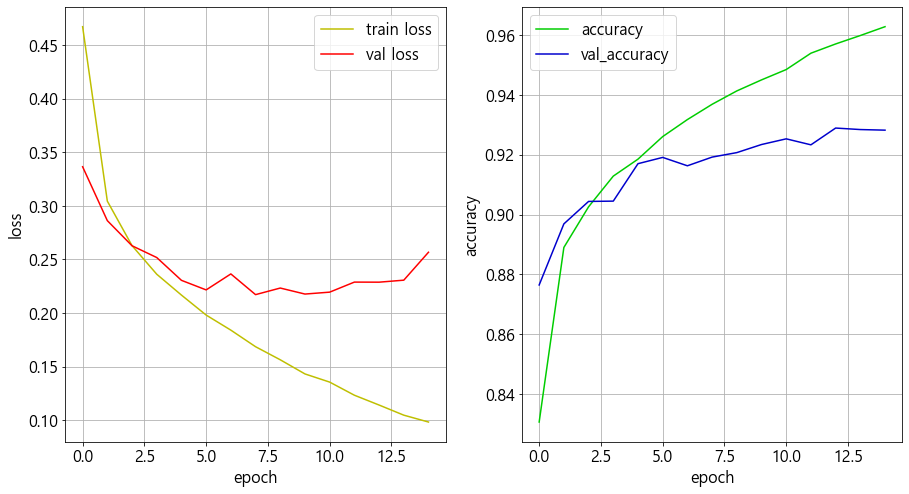

In [11]:
from matplotlib import pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (15, 8)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(hist.history['loss'], 'y', label = 'train loss')
ax1.plot(hist.history['val_loss'], 'r', label = 'val loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend(bbox_to_anchor = (1,1))

ax2.plot(hist.history['accuracy'], color = '#00cd00', label = 'accuracy')
ax2.plot(hist.history['val_accuracy'], color = '#0000cd', label = 'val_accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()


plt.show()

### 학습된 모델을 통해 값 예측하기

- set_printoptions -> 출력 옵션 변경 함수
- precision --> 소수점 자리수를 의미

In [12]:
import numpy as np

np.set_printoptions(precision = 7) # numpy 소수점 제한

result = model.predict(x_test)

- 테스트 데이터 크기 확인

In [13]:
print(result.shape)
data_count, case_count = result.shape

print('%d개의 검증 데이터가 각각 %d개의 경우의 수를 갖는다.' % (data_count, case_count))

(10000, 10)
10000개의 검증 데이터가 각각 10개의 경우의 수를 갖는다.


- 가장 큰 확률 값의 인덱스 리스트

In [14]:
arg_results = np.argmax(result, axis = -1)
arg_results

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

### 예측값 그려서 확인해보기

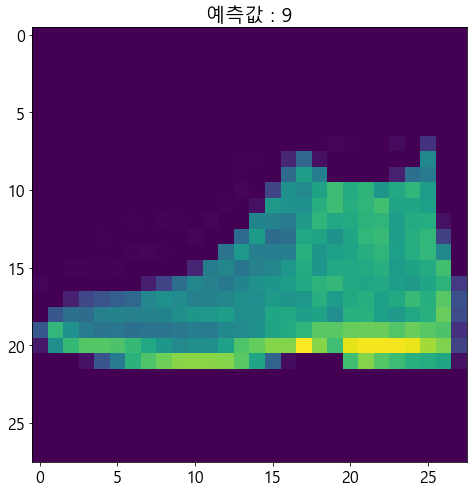

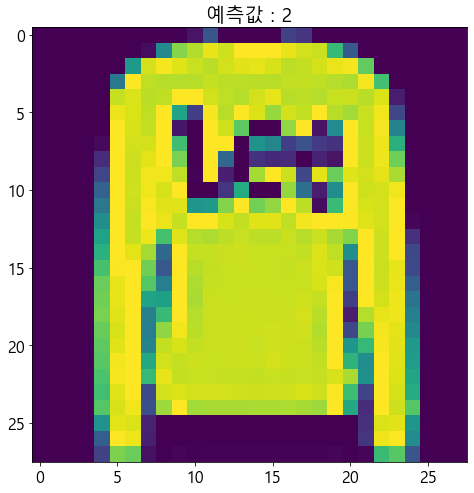

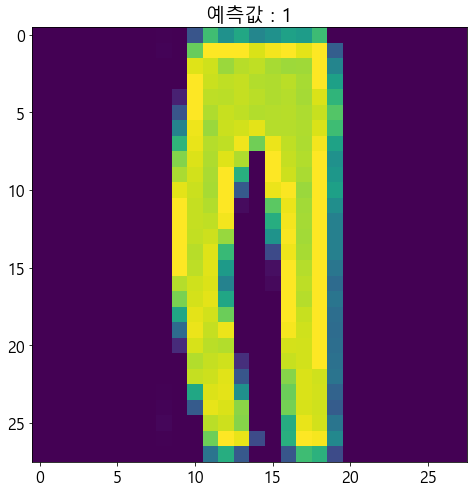

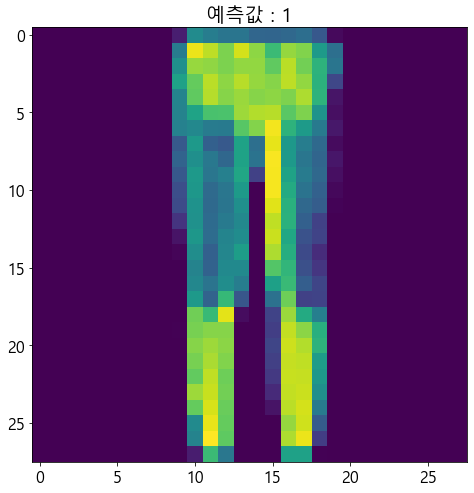

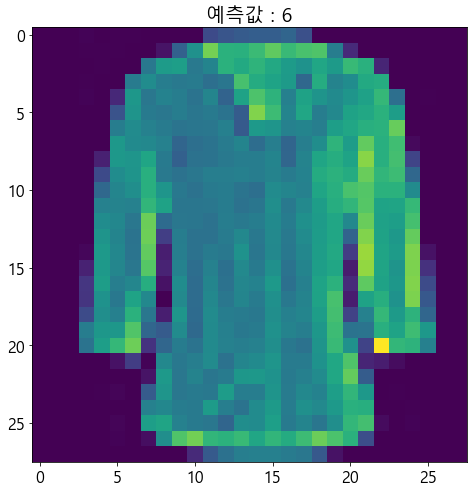

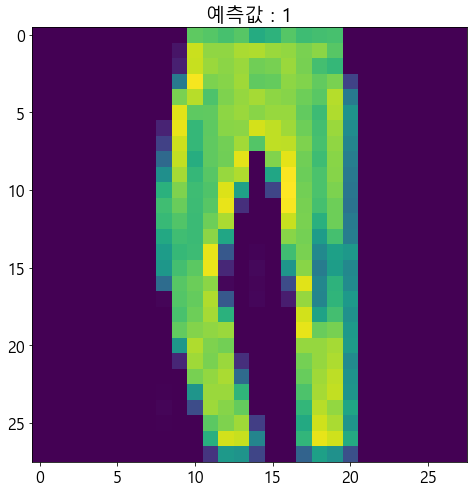

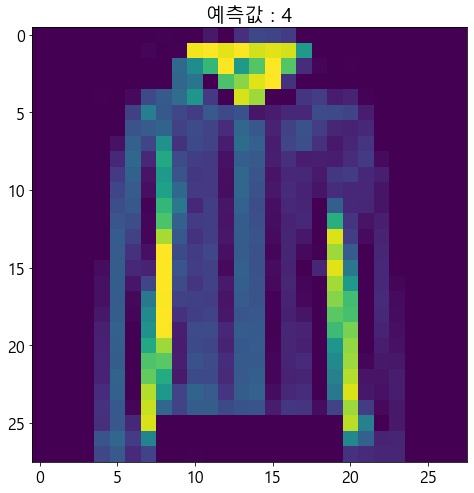

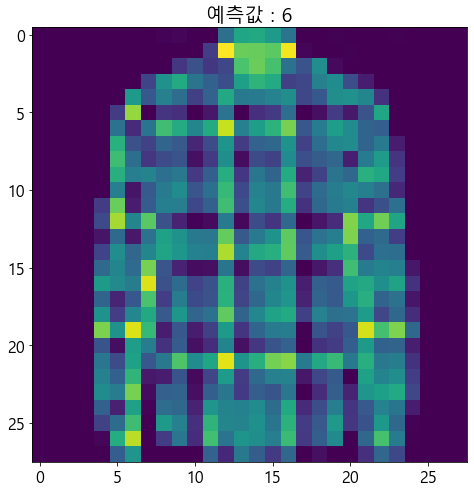

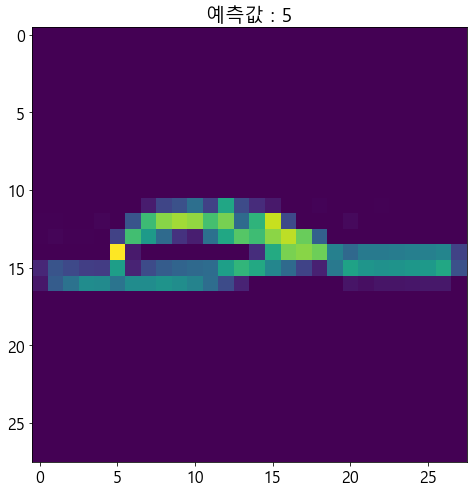

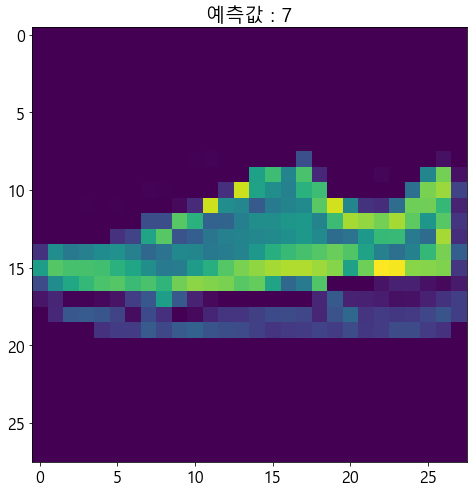

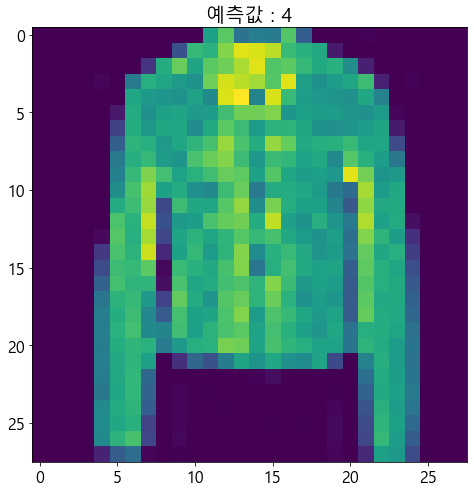

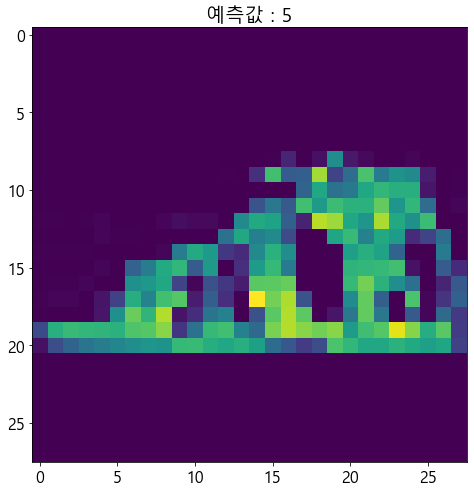

In [15]:
for i, v in enumerate(arg_results):
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title('예측값 : ' + str(v))
    plt.show()
    
    if i > 10:
        break

### 모델 평가 방법 1 - 오차행렬

- 숫자가 골고루 퍼져 있을수록 혼란스러워했음을 의미
- 예측 데이터(ca_y_test)를 x축으로, 결과 데이터(result)를 y축으로 놓는 오차행렬(confusion_matrix) 생성하기

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis = -1), np.argmax(result, axis = -1))
cm

array([[899,   0,  10,  17,   2,   1,  63,   0,   8,   0],
       [  1, 988,   0,   9,   0,   0,   1,   0,   1,   0],
       [ 21,   1, 862,   8,  61,   0,  47,   0,   0,   0],
       [ 10,   3,   8, 951,  15,   0,  12,   0,   1,   0],
       [  1,   0,  38,  23, 897,   0,  41,   0,   0,   0],
       [  0,   0,   0,   0,   0, 996,   0,   4,   0,   0],
       [105,   0,  40,  30,  51,   0, 769,   0,   5,   0],
       [  0,   0,   0,   0,   0,  11,   0, 976,   0,  13],
       [  2,   0,   0,   4,   1,   3,   0,   1, 989,   0],
       [  0,   0,   0,   0,   0,  11,   1,  33,   0, 955]], dtype=int64)

### 오차행렬 시각화

- 5를 분류할 때 가장 많이 혼란스러워한다.
- 오차행렬은 모델의 강점과 약점을 파악하기에 유용하다.

> 오차행렬을 히트맵 그래프로 표현
- annot: 그래프의 각 칸에 수치값 출력
- fmt: 수치값 출력 format(여기서는 10진수)
- cmap: 색상맵(https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)

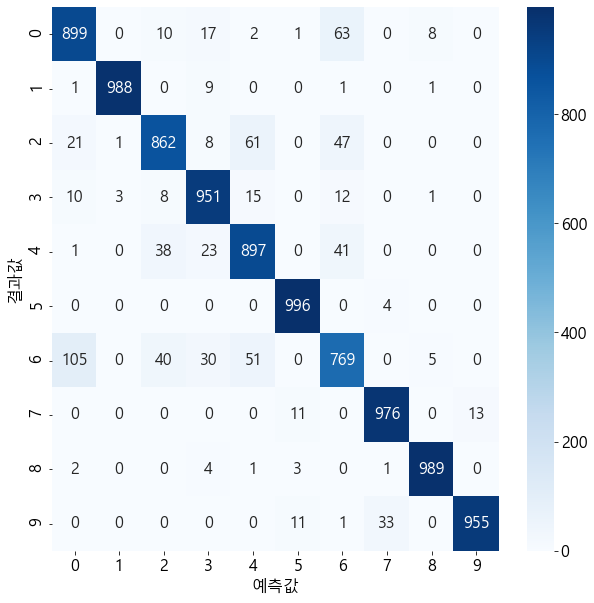

In [17]:
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 10)

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('예측값')
plt.ylabel('결과값')

plt.show()

### 모델 평가 방법 2 - 분류 보고서

In [18]:
from pandas import DataFrame

reports = classification_report(np.argmax(y_test, axis = -1), 
                               np.argmax(result, axis = -1),
                              output_dict = True)

DataFrame(reports).transpose()

,precision,recall,f1-score,support
0,0.865255,0.8990,0.881805,1000.0000
1,0.995968,0.9880,0.991968,1000.0000
2,0.899791,0.8620,0.880490,1000.0000
3,0.912668,0.9510,0.931440,1000.0000
4,0.873418,0.8970,0.885052,1000.0000
5,0.974560,0.9960,0.985163,1000.0000
6,0.823340,0.7690,0.795243,1000.0000
7,0.962525,0.9760,0.969215,1000.0000
8,0.985060,0.9890,0.987026,1000.0000
9,0.986570,0.9550,0.970528,1000.0000
